# Somatic Mutations

The goal of this notebook is to introduce you to the Somatic Mutations BigQuery table.

This table is based on the open-access somatic mutation calls available in [MAF files](https://wiki.nci.nih.gov/display/TCGA/TCGA+MAF+Files) at the DCC.  In addition to uploading all current MAF files from the DCC, the mutations were also annotated using [Oncotator](https://www.broadinstitute.org/cancer/cga/oncotator).  A subset of the columns in the underlying MAF files and a subset of the Oncotator outputs were then assembled in this table.  

In addition, the ETL process includes several data-cleaning steps because many tumor types actually have multiple current MAF files and therefore potentially duplicate mutation calls.  In some cases, a tumor sample may have had mutations called relative to both a blood-normal and an adjacent-tissue sample, and in other cases MAF files may contain mutations called on more than one aliquot from the same sample.  Every effort was made to include all of the available data at the DCC while avoiding having multiple rows in the mutation table describing the same somatic mutation.  Note, however, that if the *same* mutation was called by *multiple* centers and appeared in different MAF files, it may be described on muliple rows (as you will see later in this notebook).  Furthermore, in some cases, the underlying MAF file may have been based on a multi-center mutationa-calling exercise, in which case you may see a list of centers in the `Center` field, *eg* "bcgsc.ca;broad.mit.edu;hgsc.bcm.edu;mdanderson.org;ucsc.edu". 

In conclusion, if you are counting up the number of mutations observed in a sample or a patient or a tumor-type, be sure to include the necessary GROUP BY clause(s) in order to avoid double-counting!

As usual, in order to work with BigQuery, you need to import the bigquery module (gcp.bigquery) and you need to know the name(s) of the table(s) you are going to be working with:

In [1]:
import gcp.bigquery as bq
somatic_mutations_BQtable = bq.Table('isb-cgc:tcga_201510_alpha.Somatic_Mutation_calls')

Let's start by taking a look at the table schema:

In [2]:
%bigquery schema --table $somatic_mutations_BQtable

That's a lot of fields!  Let's dig in a bit further to see what is included in this table.  For example let's count up the number of unique patients, tumor-samples, and normal-samples based on barcode identifiers:

In [3]:
%%sql --module count_unique

SELECT COUNT(DISTINCT $f,25000) AS n
FROM $t

In [4]:
fieldList = ['ParticipantBarcode', 'Tumor_SampleBarcode', 'Normal_SampleBarcode' ]
for aField in fieldList:
  field = somatic_mutations_BQtable.schema[aField]
  rdf = bq.Query(count_unique,t=somatic_mutations_BQtable,f=field).to_dataframe()
  print " There are %6d unique values in the field %s. " % ( rdf.iloc[0]['n'], aField)

 There are   8373 unique values in the field ParticipantBarcode. 
 There are   8435 unique values in the field Tumor_SampleBarcode. 
 There are   8754 unique values in the field Normal_SampleBarcode. 


Now let's look at a few key fields and find the top-5 most frequent values in each field:

In [5]:
%%sql --module top_5_values

SELECT $f, COUNT(*) AS n
FROM $t
WHERE ( $f IS NOT NULL )
GROUP BY $f
ORDER BY n DESC
LIMIT 5

You can use the parameterized query defined above to find the top-5 most frequently occurring values for any field of interest, for example:

In [6]:
bq.Query(top_5_values,t=somatic_mutations_BQtable,f=somatic_mutations_BQtable.schema['Hugo_Symbol']).results().to_dataframe()

,Hugo_Symbol,n
0,Unknown,66354
1,TTN,24171
2,MUC16,15058
3,FLG,13068
4,OBSCN,7986


In [7]:
bq.Query(top_5_values,t=somatic_mutations_BQtable,f=somatic_mutations_BQtable.schema['Center']).results().to_dataframe()

,Center,n
0,broad.mit.edu,3998891
1,bcgsc.ca,646933
2,hgsc.bcm.edu,485994
3,genome.wustl.edu,374934
4,ucsc.edu,190786


In [8]:
bq.Query(top_5_values,t=somatic_mutations_BQtable,f=somatic_mutations_BQtable.schema['Mutation_Status']).results().to_dataframe()

,Mutation_Status,n
0,Somatic,5813176


In [9]:
bq.Query(top_5_values,t=somatic_mutations_BQtable,f=somatic_mutations_BQtable.schema['Protein_Change']).results().to_dataframe()

,Protein_Change,n
0,p.M1I,2352
1,p.V600E,1243
2,p.R132H,1042
3,p.E545K,624
4,p.M1V,553


Everyone probably recognizes the **V600E** mutation in the previous result, so let's use that well-known BRAF mutation as a way to explore what other information is available in this table.

In [10]:
%%sql --module find_BRAF_V600E

SELECT
  Tumor_SampleBarcode,
  Study,
  Hugo_Symbol,
  Genome_Change,
  Protein_Change
FROM
  $t
WHERE
  ( Hugo_Symbol="BRAF"
    AND Protein_Change="p.V600E" )
GROUP BY
  Tumor_SampleBarcode,
  Study,
  Hugo_Symbol,
  Genome_Change,
  Protein_Change
ORDER BY
  Study,
  Tumor_SampleBarcode

In [11]:
r = bq.Query(find_BRAF_V600E,t=somatic_mutations_BQtable).results()
r.to_dataframe()

,Tumor_SampleBarcode,Study,Hugo_Symbol,Genome_Change,Protein_Change
0,TCGA-YF-AA3L-01A,BLCA,BRAF,g.chr7:140453136A>T,p.V600E
1,TCGA-ZU-A8S4-01A,CHOL,BRAF,g.chr7:140453136A>T,p.V600E
2,TCGA-A6-5661-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
3,TCGA-A6-5665-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
4,TCGA-A6-6649-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
5,TCGA-A6-6653-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
6,TCGA-AA-3492-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
7,TCGA-AA-3713-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
8,TCGA-AD-5900-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E
9,TCGA-AD-6889-01A,COAD,BRAF,g.chr7:140453136A>T,p.V600E


Let's count these mutations up by study (tumor-type):

In [12]:
%%sql

SELECT Study, COUNT(*) AS n
FROM $r
GROUP BY Study
HAVING n > 1
ORDER BY n DESC

QueryResultsTable job_X9LPh4mr1LtnU51fnCoOzrcWr-w

You may have noticed that in our earlier query, we did a GROUP BY to make sure that we didn't count the same mutation called on the same sample more than once.  We might want to GROUP BY patient instead to see if that changes our counts -- we may have multiple samples from some patients.

In [13]:
%%sql --module find_BRAF_V600E_by_patient

SELECT
  ParticipantBarcode,
  Study,
  Hugo_Symbol,
  Genome_Change,
  Protein_Change
FROM
  $t
WHERE
  ( Hugo_Symbol="BRAF"
    AND Protein_Change="p.V600E" )
GROUP BY
  ParticipantBarcode,
  Study,
  Hugo_Symbol,
  Genome_Change,
  Protein_Change
ORDER BY
  Study,
  ParticipantBarcode

In [14]:
r = bq.Query(find_BRAF_V600E_by_patient,t=somatic_mutations_BQtable).results()

In [15]:
%%sql

SELECT Study, COUNT(*) AS n
FROM $r
GROUP BY Study
HAVING n > 1
ORDER BY n DESC

QueryResultsTable job_MsZwpNlK9BpdtYTHuFGrgc5mD-Y

When we counted the number of mutated samples, we found 261 THCA samples, but when we counted the number of patients, we found 258 THCA patients, so let's see what's going on there.

In [16]:
%%sql

SELECT
  ParticipantBarcode,
  COUNT(*) AS m
FROM (
  SELECT
    ParticipantBarcode,
    Tumor_SampleBarcode,
    COUNT(*) AS n
  FROM
    $somatic_mutations_BQtable
  WHERE
    ( Hugo_Symbol="BRAF"
      AND Protein_Change="p.V600E"
      AND Study="THCA" )
  GROUP BY
    ParticipantBarcode,
    Tumor_SampleBarcode,
    )
GROUP BY
  ParticipantBarcode
HAVING
  m > 1
ORDER BY
  m DESC

QueryResultsTable job_XfBcCR38xWN1l9-sINmPTTH_O2g

Sure enough, we see that the same mutation is reported twice for each of these three patients.  Let's look at why:

In [17]:
%%sql

SELECT
  ParticipantBarcode,
  Tumor_SampleBarcode,
  Tumor_SampleTypeLetterCode,
  Normal_SampleBarcode,
  Normal_SampleTypeLetterCode,
  Center,
FROM
  $somatic_mutations_BQtable
WHERE
  ( Hugo_Symbol="BRAF"
    AND Protein_Change="p.V600E"
    AND Study="THCA"
    AND ParticipantBarcode="TCGA-EM-A2P1" )
ORDER BY
  Tumor_SampleBarcode,
  Normal_SampleBarcode,
  Center

QueryResultsTable job_X4VNdmHnSQ0H6eD9FFle8C_kPOM

Aha!  not only did this patient provide both a primary tumor (TP) and a metastatic (TM) sample, but we have mutation calls from three different centers.

Finally, let's pick out one of these mutations and see what some of the other fields in this table can tell us:

In [18]:
%%sql

SELECT
  ParticipantBarcode,
  Tumor_SampleTypeLetterCode,
  Normal_SampleTypeLetterCode,
  Study,
  Center,
  Variant_Type,
  Variant_Classification,
  Genome_Change,
  cDNA_Change,
  Protein_Change,
  UniProt_Region,
  COSMIC_Total_Alterations_In_Gene,
  DrugBank
FROM
  $somatic_mutations_BQtable
WHERE
  ( Hugo_Symbol="BRAF"
    AND Protein_Change="p.V600E"
    AND Study="THCA"
    AND ParticipantBarcode="TCGA-EM-A2P1"
    AND Tumor_SampleTypeLetterCode="TP"
    AND Center="broad.mit.edu" )

QueryResultsTable job_XxKX0daBQnDz3jKa8YgxwnArvZ4

When working with variants or mutations, there is another public BigQuery table that you might find useful.  Developed by [Tute Genomics](http://tutegenomics.com/), this comprehensive, publicly-available database of over 8.5 billion known variants was [announced](https://www.tutegenomics.com/news/exploring-genetic-variation-with-google-genomics-and-tute/) earlier this year.  This table includes several types of annotations and scores, such ase [Polyphen2](http://genetics.bwh.harvard.edu/pph2/) and [MutationAssessor](http://mutationassessor.org/), and a proprietary "Tute score" which estimates whether a SNP or indel is likely to be associate with Mendelian phenotypes. 

For example, you can look up all exonic BRAF mutations in the TuteTable in less than 20 seconds:

In [19]:
%%sql --module BRAF_TUTE

SELECT
  Chr,
  Start,
  Func,
  Gene,
  AA,
  Polyphen2_HDIV_score,
  Polyphen2_HVAR_score,
  MutationAssessor_score,
  TUTE
FROM
  [silver-wall-555:TuteTable.hg19]
WHERE
  ( Gene="BRAF"
    AND Func="exonic" )
ORDER BY
  Start ASC

In [20]:
tuteBRAFscores = bq.Query(BRAF_TUTE).results().to_dataframe()
tuteBRAFscores.describe()

,Start,Polyphen2_HDIV_score,Polyphen2_HVAR_score,MutationAssessor_score,TUTE
count,6.903000e+03,4985.000000,4985.000000,4976.000000,6903.000000
mean,1.404945e+08,0.556226,0.413867,1.247881,0.332186
std,4.577719e+04,0.417165,0.395638,1.182233,0.306410
min,1.404344e+08,0.000000,0.000000,-2.770000,0.000000
25%,1.404540e+08,0.073000,0.031000,0.345000,0.108000
50%,1.404874e+08,0.664000,0.263000,1.150000,0.196700
75%,1.405087e+08,0.990000,0.870000,1.895000,0.568100
max,1.406245e+08,1.000000,1.000000,4.505000,0.931700


Let's go back to the TCGA somatic mutations table and pull out all BRAF mutations and then join them with the matching mutations in the Tute Table so that we can compare the distribution of scores (*eg* MutationAssessor and TUTE) between the somatic mutations seen in TCGA and the larger set of variants contained in the Tute Table.

In [21]:
%%sql --module TCGA_BRAF

SELECT
  Hugo_Symbol,
  Protein_Change,
  MutationAssessor_score,
  TUTE
FROM (
  SELECT
    Hugo_Symbol,
    Protein_Change
  FROM
    $t
  WHERE
    ( Hugo_Symbol="BRAF" )
  GROUP BY
    Hugo_Symbol,
    Protein_Change ) AS tcga
JOIN (
  SELECT
    Gene,
    AA,
    MutationAssessor_score,
    TUTE
  FROM
    [silver-wall-555:TuteTable.hg19]
  WHERE
    ( Gene="BRAF" ) ) AS tute
ON
  tcga.Hugo_Symbol=tute.Gene
  AND tcga.Protein_Change=tute.AA

In [22]:
tcgaBRAFscores = bq.Query(TCGA_BRAF,t=somatic_mutations_BQtable).results().to_dataframe()
tcgaBRAFscores.describe()

,MutationAssessor_score,TUTE
count,133.000000,212.000000
mean,1.565639,0.324648
std,1.464682,0.320656
min,-1.005000,0.000000
25%,0.345000,0.094000
50%,1.320000,0.186000
75%,2.455000,0.594050
max,4.475000,0.926400


In [23]:
import numpy as np
import matplotlib.pyplot as plt

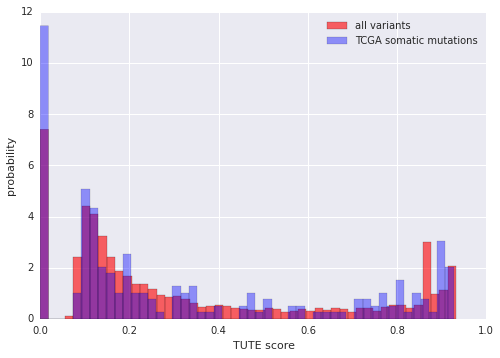

In [24]:
plt.hist(tuteBRAFscores['TUTE'],bins=50,normed=True,color='red',alpha=0.6,label='all variants');
plt.hist(tcgaBRAFscores['TUTE'],bins=50,normed=True,color='blue',alpha=0.4,label='TCGA somatic mutations');
plt.legend(loc='upper right');
plt.xlabel('TUTE score');
plt.ylabel('probability');

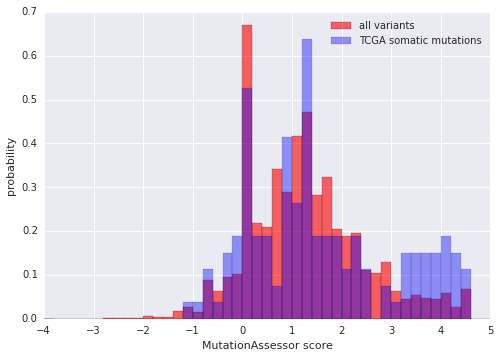

In [25]:
plt.hist(tuteBRAFscores['MutationAssessor_score'],bins=45,range=[-4,5],normed=True,color='red',alpha=0.6,label='all variants');
plt.hist(tcgaBRAFscores['MutationAssessor_score'],bins=45,range=[-4,5],normed=True,color='blue',alpha=0.4,label='TCGA somatic mutations');
plt.legend(loc='upper right');
plt.xlabel('MutationAssessor score');
plt.ylabel('probability');

Both of these plots suggest that some of the somatic BRAF mutations observed in TCGA tumor samples are scored as more deleterious by both TUTE and MutationAssessor.  In the TUTE histogram, a larger fraction of somatic mutations also get a score of 0.

Note that in these histograms, each count represents a *single* variant, *ie* a specific protein change.  Mutations that are seen across multiple patients are **not** being counted multiple times.